Found 6954 images belonging to 13 classes.
Found 1733 images belonging to 13 classes.
Found 2170 images belonging to 13 classes.


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3761 - loss: 7.7450

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


218/218 ━━━━━━━━━━━━━━━━━━━━ 2554s 12s/step - accuracy: 0.3771 - loss: 7.7410 - val_accuracy: 0.7894 - val_loss: 5.8403 - learning_rate: 1.0000e-04
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2354s 11s/step - accuracy: 0.8959 - loss: 5.3953 - val_accuracy: 0.8177 - val_loss: 5.0467 - learning_rate: 1.0000e-04
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2342s 11s/step - accuracy: 0.9542 - loss: 4.4746 - val_accuracy: 0.9100 - val_loss: 4.0801 - learning_rate: 1.0000e-04
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 13841s 64s/step - accuracy: 0.9737 - loss: 3.7222 - val_accuracy: 0.9100 - val_loss: 3.4405 - learning_rate: 1.0000e-04
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 1718s 8s/step - accuracy: 0.9804 - loss: 3.0685 - val_accuracy: 0.9002 - val_loss: 2.9051 - learning_rate: 1.0000e-04
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 1734s 8s/step - accuracy: 0.9850 - loss: 2.5038 - val_accuracy: 0.9446 - val_loss: 2.2745 - learning_rate: 1.0000e-04
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 1831s 8s/step - ac

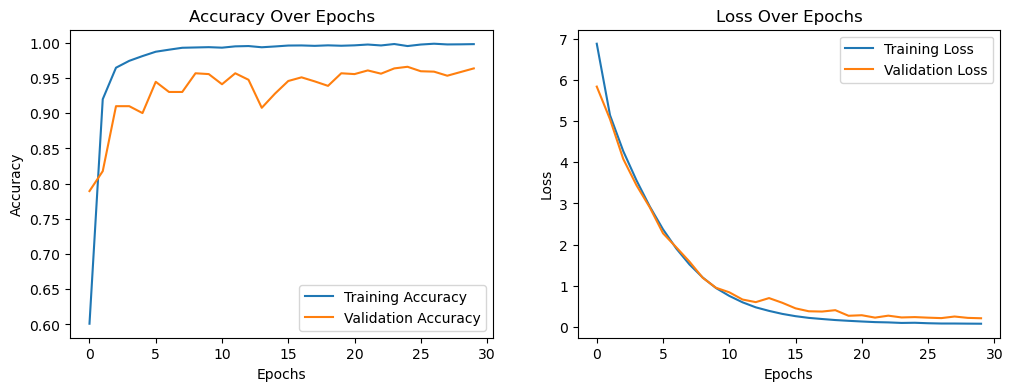

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Dataset paths
dataset_dir = "D:/Academic/4th year/Research/NewDataset"  # Update with the correct path
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

# Image data generators for augmentation and preprocessing
img_height, img_width = 224, 224  # MobileNetV2 requires input size of at least 224x224
batch_size = 32

# Training data generator with enhanced augmentations
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   brightness_range=[0.8, 1.2],
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)  # 20% for validation

# Training and validation generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     subset='training')

val_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   subset='validation')

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=False)

# Load the pre-trained MobileNetV2 model without the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Unfreeze the top layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze the first 100 layers
    layer.trainable = False

# Add custom classification layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Increased neurons and L2 regularization
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')  # Adjust to the number of classes
])

# Compile the model with a reduced learning rate
model.compile(optimizer=Adam(learning_rate=1e-4),  # Smaller learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=30,
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()


In [5]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageDraw, ImageFont

# Constants
model_save_path = "leaf_identifyer.h5"
img_height, img_width = 224, 224  # Ensure these match your model's input size
output_folder = "D:/Academic/4th year/Research/results"  # Folder to save annotated images

# Load the trained model
def load_and_save_predictions(folder_path):
    # Load the saved model
    loaded_model = load_model(model_save_path)
    
    # Reverse the class indices to map predictions to class names
    class_indices = {v: k for k, v in train_generator.class_indices.items()}
    
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Iterate over all files in the folder
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        
        if not img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
            # Skip files that are not images
            print(f"Skipping non-image file: {img_file}")
            continue
        
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(img_height, img_width))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Predict the class
        prediction = loaded_model.predict(img_array)
        predicted_class = class_indices[np.argmax(prediction)]
        
        # Annotate and save the image
        save_annotated_image(img_path, img_file, predicted_class)

# Function to annotate and save the image
def save_annotated_image(img_path, img_file, predicted_class):
    # Open the original image
    original_img = Image.open(img_path)
    
    # Create a drawing context
    draw = ImageDraw.Draw(original_img)
    
    # Define font (use default if custom font isn't available)
    try:
        font = ImageFont.truetype("arial.ttf", size=20)
    except IOError:
        font = ImageFont.load_default()
    
    # Add the prediction text
    text = f"Prediction: {predicted_class}"
    text_position = (10, 10)  # Top-left corner
    text_color = (255, 0, 0)  # Red color
    
    draw.text(text_position, text, fill=text_color, font=font)
    
    # Save the annotated image in the output folder
    output_path = os.path.join(output_folder, img_file)
    original_img.save(output_path)
    print(f"Saved annotated image: {output_path}")

# Folder path containing test images
folder_path = 'D:/Academic/4th year/Research/test_folder'
load_and_save_predictions(folder_path)


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'leaf_identifyer.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [7]:
import os

if os.path.exists(model_save_path):
    print("File exists.")
else:
    print("File not found.")


File not found.


In [9]:
import os
print("Current Working Directory:", os.getcwd())


Current Working Directory: C:\Users\HP
